In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# EDA

- correlation matrix
- distribution of predictors
- look for class imbalances

In [5]:
# load dataset
diabetes = pd.read_csv('diabetes_prediction_dataset.csv')
diabetes.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [6]:
# summary stats
diabetes.shape

(100000, 9)

In [7]:
# get info on the predictors
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


The dataset I downloaded from kaggle has no missing values, so that makes things a lot easier for me. There are some non numeric variables, which I need to encode to numeric type before any sort of modeling.

In [30]:
# get the unique values for non continuous columns
print(f"gender: {diabetes['gender'].unique()}")
print(f"hypertension: {diabetes['hypertension'].unique()}")
print(f"heart_disease: {diabetes['heart_disease'].unique()}")
print(f"smoking_history: {diabetes['smoking_history'].unique()}")

gender: ['Female' 'Male' 'Other']
hypertension: [0 1]
heart_disease: [1 0]
smoking_history: ['never' 'No Info' 'current' 'former' 'ever' 'not current']


In [13]:
diabetes['diabetes'].value_counts(normalize=True)

diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64

Another thing to consider is class imbalance. 91.5% of the observations do not have diabetes and only 8.5% have diabetes.

Now I will create histograms to visualize how the numerical variables are distributed. For non numeric variables I will user bar charts.

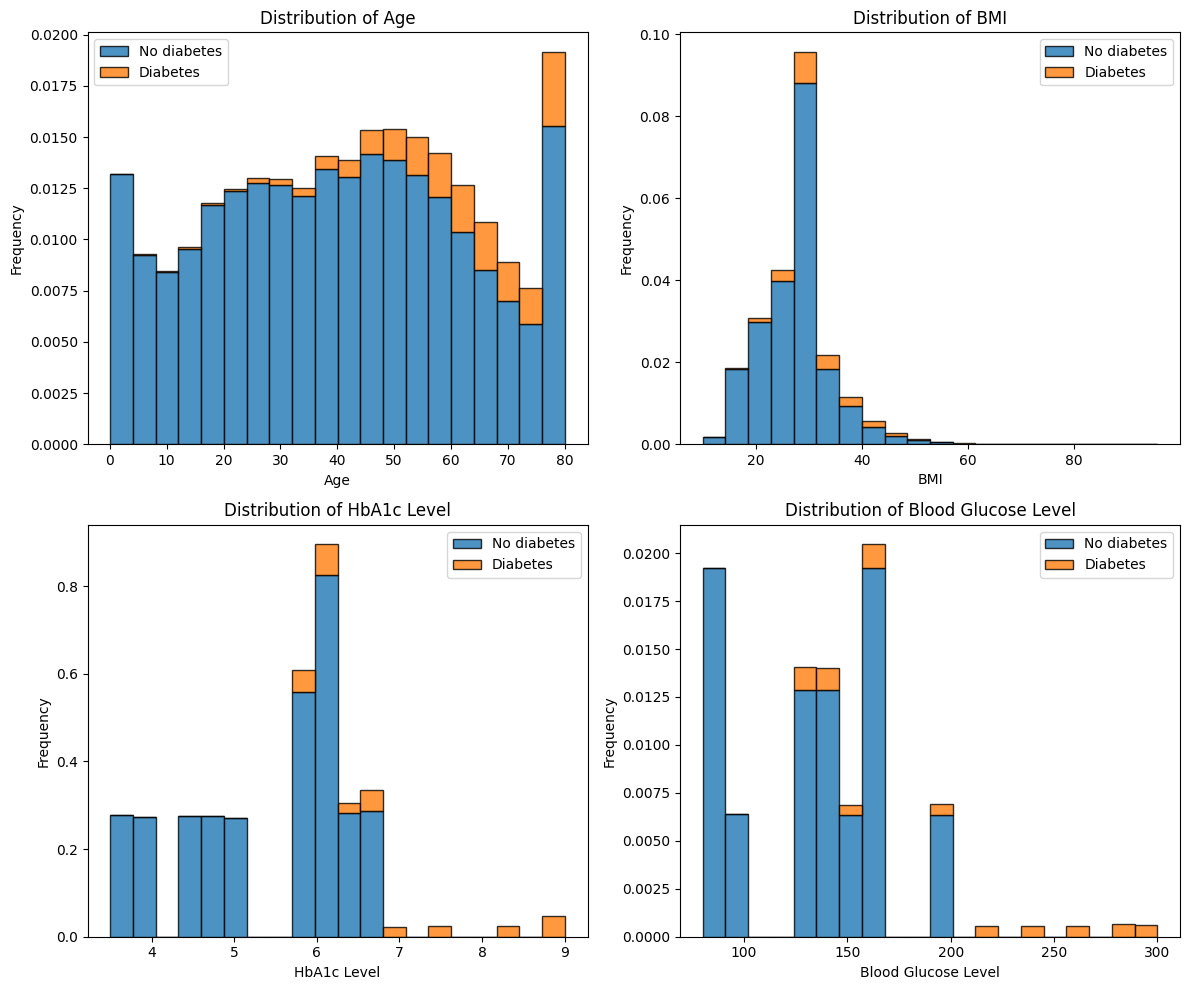

In [22]:
diabetes_yes = diabetes[diabetes['diabetes'] == 1]
diabetes_no = diabetes[diabetes['diabetes'] == 0]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Variables and titles
numeric_variables = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
titles = ['Distribution of Age', 'Distribution of BMI', 'Distribution of HbA1c Level', 'Distribution of Blood Glucose Level']
xlabels = ['Age', 'BMI', 'HbA1c Level', 'Blood Glucose Level']

for i, (var, title, xlabel) in enumerate(zip(numeric_variables, titles, xlabels)):
    axes[i].hist(
        [diabetes_no[var], diabetes_yes[var]],
        bins=20,
        edgecolor='black',
        alpha=0.8,
        label=['No diabetes', 'Diabetes'],
        stacked=True,
        density=True
    )
    axes[i].set_xlabel(xlabel)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(title)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [42]:
# correlation matrix of continuous variables
corr_matrix = diabetes[numeric_variables].corr()
print(corr_matrix)

                          age       bmi  HbA1c_level  blood_glucose_level
age                  1.000000  0.337396     0.101354             0.110672
bmi                  0.337396  1.000000     0.082997             0.091261
HbA1c_level          0.101354  0.082997     1.000000             0.166733
blood_glucose_level  0.110672  0.091261     0.166733             1.000000


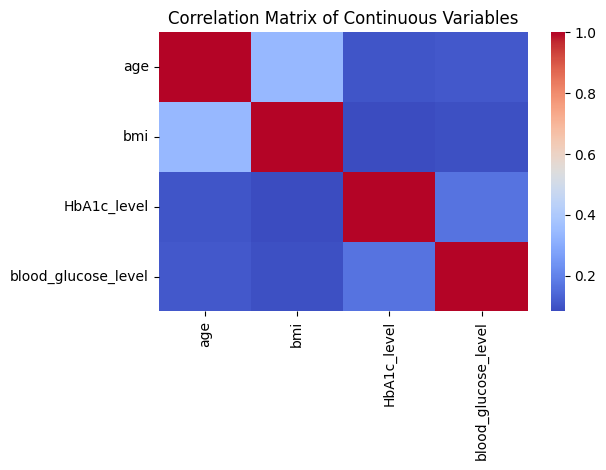

In [46]:
# visualize correlation matrix as a heatmap
sns.heatmap(
    corr_matrix,
    cmap='coolwarm'
)
plt.title('Correlation Matrix of Continuous Variables')
plt.tight_layout()
plt.show()

There does not appear to be strong correlation between any of the numerical variables.

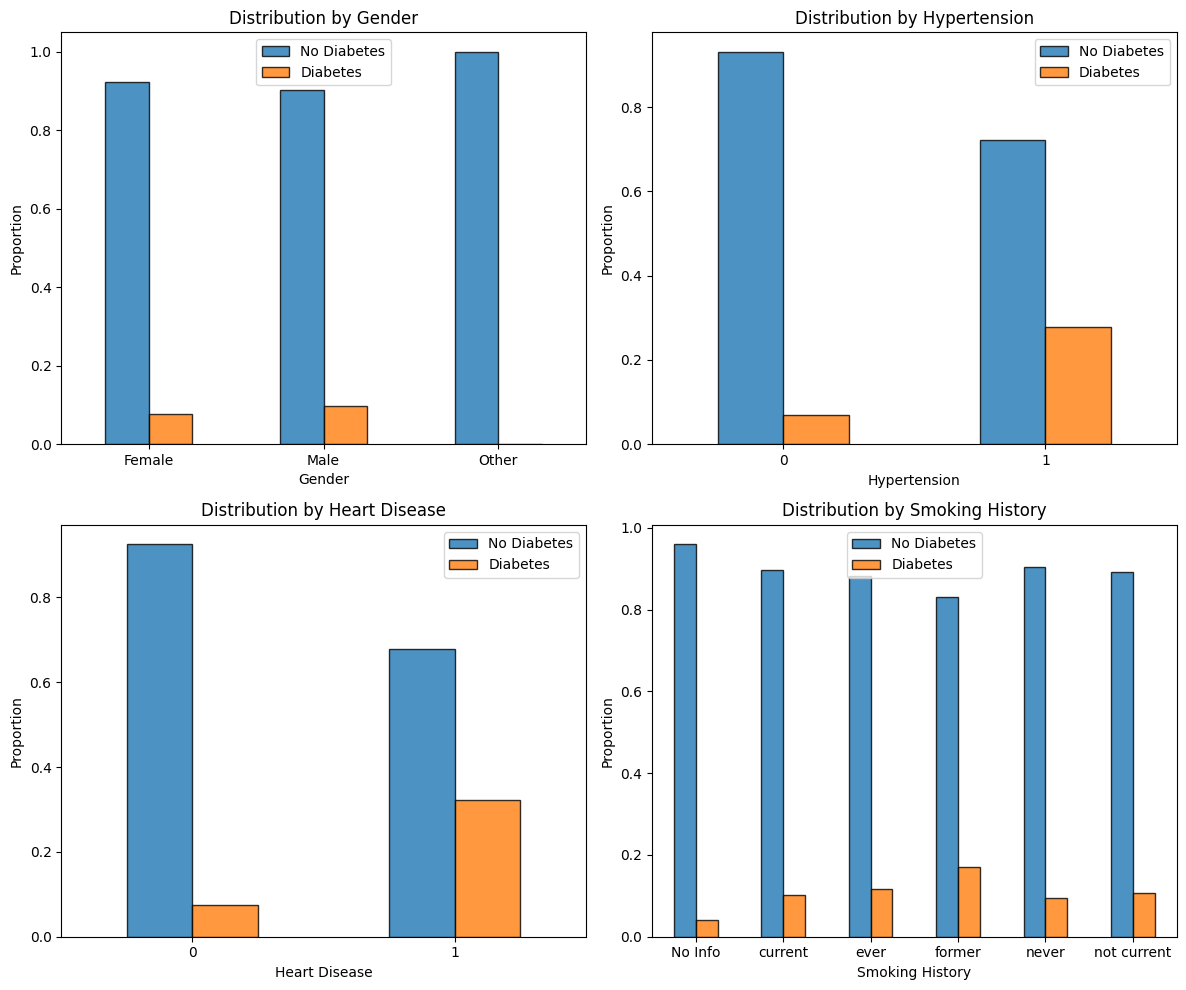

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

categorical_variables = ['gender', 'hypertension', 'heart_disease', 'smoking_history']
titles = ['Distribution by Gender', 'Distribution by Hypertension', 'Distribution by Heart Disease', 'Distribution by Smoking History']

for i, (var, title) in enumerate(zip(categorical_variables, titles)):
    # Create crosstab with proportions
    crosstab = pd.crosstab(diabetes[var], diabetes['diabetes'], normalize='index')
    
    crosstab.plot(kind='bar', ax=axes[i], 
                  alpha=0.8, 
                  edgecolor='black')
    
    axes[i].set_title(title)
    axes[i].set_xlabel(var.replace('_', ' ').title())
    axes[i].set_ylabel('Proportion')
    axes[i].legend(['No Diabetes', 'Diabetes'])
    axes[i].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Data Preprocessing

- deal with categorical variables
- train test split
- cross validation grid for hyperparameter tuning

I need to encode the categorical predictors so they can be used in a model. 

`hypertension` and `heart_disease` can only be 0 or 1, so they do not require additional encoding.

For `gender`, I will use one hot encoding since the data is nominal.

For `smoking_history`, I will use ordinal encoding there is an inherent order in the range of possible responses.

In [39]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# gender: one hot encoding
gender_encoder = OneHotEncoder(sparse_output=False, drop='first')
gender_encoded = gender_encoder.fit_transform(diabetes[['gender']])

# Create proper column names for the encoded features
feature_names = gender_encoder.get_feature_names_out(['gender'])
gender_df = pd.DataFrame(gender_encoded, columns=feature_names)

gender_df.head()

,gender_Male,gender_Other
0,0.0,0.0
1,0.0,0.0
2,1.0,0.0
3,0.0,0.0
4,1.0,0.0


The encoding creates 2 dummy variables for Male and Other, while dropping the Female category. It does this because any row with 0 for both Male and Other is automatically assumed to be Female

In [38]:
# smoking history: ordinal encoding
smoking_categories = [['never', 'No Info', 'former', 'not current', 'ever', 'current']]
smoking_encoder = OrdinalEncoder(categories=smoking_categories)
smoking_encoded = smoking_encoder.fit_transform(diabetes[['smoking_history']])

print(smoking_encoded)

[[0.]
 [1.]
 [0.]
 ...
 [2.]
 [0.]
 [5.]]


In [40]:
# replace gender and smoking history columns with encodings
diabetes.drop(['gender', 'smoking_history'], axis=1, inplace=True)

diabetes = pd.concat([diabetes, gender_df], axis=1)
diabetes['smoking_history'] = smoking_encoded.flatten()

diabetes.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,gender_Other,smoking_history
0,80.0,0,1,25.19,6.6,140,0,0.0,0.0,0.0
1,54.0,0,0,27.32,6.6,80,0,0.0,0.0,1.0
2,28.0,0,0,27.32,5.7,158,0,1.0,0.0,0.0
3,36.0,0,0,23.45,5.0,155,0,0.0,0.0,5.0
4,76.0,1,1,20.14,4.8,155,0,1.0,0.0,5.0


In [47]:
from sklearn.model_selection import train_test_split

X = diabetes.drop('diabetes', axis=1)
y = diabetes['diabetes']

# stratify y to maintain class balance in train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=66, stratify=y)

Before training the models, I will set up some paramater grids and cross validation for hyperparameter tuning.

In [53]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# set up cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=66)

In [54]:
# random forest parameter grid
rf_grid = {
    'n_estimators': [100, 200, 300],           # Number of trees
    'max_depth': [10, 20, None],               # Maximum depth of trees
    'min_samples_split': [2, 5, 10],           # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],             # Minimum samples in leaf node
    'max_features': ['sqrt', 'log2', None],    # Number of features to consider
    'bootstrap': [True, False],                # Whether to bootstrap samples
    'class_weight': ['balanced', None]         # Handle class imbalance
}

# smaller grid in case training too slow
rf_grid_small = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', None]
}

In [87]:
# KNN parameter grid
knn_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21],             # Number of neighbors
    'weights': ['uniform', 'distance'],                  # Weight function
    'metric': ['euclidean', 'manhattan', 'minkowski'],   # Distance metric
    'p': [1, 2],                                         # Power parameter for minkowski
    'algorithm': ['auto', 'ball_tree', 'kd_tree']        # Algorithm for computing neighbors
}

# Smaller KNN grid for faster testing
knn_grid_small = {
    'n_neighbors': [3, 5, 7, 11, 15, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

In [ ]:
# XGBoost parameter grid
xgb_grid = {
    'n_estimators': [100, 200, 300],                   # Number of boosting rounds
    'max_depth': [3, 6, 9],                            # Maximum tree depth
    'learning_rate': [0.01, 0.1, 0.2],                 # Step size shrinkage
    'subsample': [0.8, 0.9, 1.0],                      # Fraction of samples per tree
    'colsample_bytree': [0.8, 0.9, 1.0],               # Fraction of features per tree
    'reg_alpha': [0, 0.1, 1],                          # L1 regularization
    'reg_lambda': [1, 1.5, 2],                         # L2 regularization
    'scale_pos_weight': [1, 5, 10]                     # Handle class imbalance
}

# Smaller XGBoost grid
xgb_grid_small = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.2],
    'scale_pos_weight': [1, 5]
}

In [ ]:
# SVM parameter grid
svm_grid = {
    'C': [0.1, 1, 10, 100],                           # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],              # Kernel type
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Kernel coefficient
    'degree': [2, 3, 4],                              # Degree for poly kernel
    'class_weight': ['balanced', None]                # Handle class imbalance
}

# Smaller SVM grid
svm_grid_small = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 0.01, 0.1],
    'class_weight': ['balanced', None]
}

# Logistic Regression

This will serve as the baseline model for this classification since logistic regression is the simplest model.

In [63]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(
    random_state=66,
    class_weight='balanced',
    max_iter=1000
)

# fit model
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

To evaluate the performance of this logistic regression, I will look at the confusion matrix and generate a ROC AUC score.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# confusion matrix
cm_lr = confusion_matrix(y_test, y_pred)
print(cm_lr)

[[16222  2078]
 [  209  1491]]


In [66]:
# get stats like precision, recall
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.89      0.93     18300
           1       0.42      0.88      0.57      1700

    accuracy                           0.89     20000
   macro avg       0.70      0.88      0.75     20000
weighted avg       0.94      0.89      0.90     20000



In [70]:
# roc auc score
roc_auc_lr = roc_auc_score(y_test, y_pred)
print(roc_auc_lr)

0.881753455480553


# Random Forest

In [72]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=66)

rf_grid_search = GridSearchCV(
    estimator=rf,
    param_grid=rf_grid_small,
    cv=cv,
    scoring='roc_auc',
    n_jobs=1,
    verbose=1
)

rf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


,estimator,RandomForestC...ndom_state=66)
,param_grid,"{'class_weight': ['balanced', None], 'max_depth': [10, 20], 'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 5], ...}"
,scoring,'roc_auc'
,n_jobs,1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [75]:
# best parameters and cross-validation roc auc score
print(f"Best params: {rf_grid_search.best_params_}")
print(f"Best cross validation ROC AUC score: {rf_grid_search.best_score_}")

Best params: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
Best cross validation ROC AUC score: 0.9766621765509484


In [76]:
# get best model, generate predictions
best_rf = rf_grid_search.best_estimator_
rf_pred = best_rf.predict(X_test)

# metrics
cm_rf = confusion_matrix(y_test, rf_pred)
print(cm_rf)

[[16513  1787]
 [  136  1564]]


In [77]:
# get stats like precision, recall
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94     18300
           1       0.47      0.92      0.62      1700

    accuracy                           0.90     20000
   macro avg       0.73      0.91      0.78     20000
weighted avg       0.95      0.90      0.92     20000



In [78]:
roc_auc_rf = roc_auc_score(y_test, rf_pred)
print(roc_auc_rf)

0.911174863387978


# KNN

In [88]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

knn_grid_search = GridSearchCV(
    estimator=knn,
    param_grid=knn_grid_small,
    cv=cv,
    scoring='roc_auc',
    n_jobs=1,
    verbose=1    
)

knn_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,estimator,KNeighborsClassifier()
,param_grid,"{'metric': ['euclidean', 'manhattan'], 'n_neighbors': [3, 5, ...], 'weights': ['uniform', 'distance']}"
,scoring,'roc_auc'
,n_jobs,1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,21


In [89]:
# best parameters and cross-validation roc auc score
print(f"Best params: {knn_grid_search.best_params_}")
print(f"Best cross validation ROC AUC score: {knn_grid_search.best_score_}")

Best params: {'metric': 'manhattan', 'n_neighbors': 21, 'weights': 'uniform'}
Best cross validation ROC AUC score: 0.9317574734811955


In [90]:
best_knn = knn_grid_search.best_estimator_

knn_pred = best_knn.predict(X_test)

cm_knn = confusion_matrix(y_test, knn_pred)
print(cm_knn)

[[18286    14]
 [  975   725]]


In [91]:
# get stats like precision, recall
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     18300
           1       0.98      0.43      0.59      1700

    accuracy                           0.95     20000
   macro avg       0.97      0.71      0.78     20000
weighted avg       0.95      0.95      0.94     20000



In [92]:
roc_auc_knn = roc_auc_score(y_test, knn_pred)
print(roc_auc_knn)

0.712852780456445


# XGBoost

In [103]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    random_state=66,
    eval_metric='logloss'
)

xgb_grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_grid_small,
    cv=cv,
    scoring='roc_auc',
    n_jobs=1,
    verbose=1
)

xgb_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.1, 0.2], 'max_depth': [3, 6], 'n_estimators': [100, 200], 'scale_pos_weight': [1, 5]}"
,scoring,'roc_auc'
,n_jobs,1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [98]:
# best parameters and cross-validation roc auc score
print(f"Best params: {xgb_grid_search.best_params_}")
print(f"Best cross validation ROC AUC score: {xgb_grid_search.best_score_}")

Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'scale_pos_weight': 5}
Best cross validation ROC AUC score: 0.9794008357441337


In [99]:
best_xgb = xgb_grid_search.best_estimator_
xgb_pred = best_xgb.predict(X_test)

cm_xgb = confusion_matrix(y_test, xgb_pred)
print(cm_xgb)

[[17576   724]
 [  274  1426]]


In [100]:
# get stats like precision, recall
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     18300
           1       0.66      0.84      0.74      1700

    accuracy                           0.95     20000
   macro avg       0.82      0.90      0.86     20000
weighted avg       0.96      0.95      0.95     20000



In [101]:
roc_auc_xgb = roc_auc_score(y_test, xgb_pred)
print(roc_auc_xgb)

0.8996303439408551


# Support Vector Machines

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# SVM requires scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

svm = SVC(
    random_state=66,
    probability=True
)

svm_grid_search = GridSearchCV(
    estimator=svm,
    param_grid=svm_grid_small,
    cv=cv,
    scoring='roc_auc',
    n_jobs=1,
    verbose=1
)

svm_grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [ ]:
# best parameters and cross-validation roc auc score
print(f"Best params: {svm_grid_search.best_params_}")
print(f"Best cross validation ROC AUC score: {svm_grid_search.best_score_}")

In [ ]:
best_svm = svm_grid_search.best_estimator_
svm_pred = best_svm.predict(X_test_scaled)

cm_svm = confusion_matrix(y_test, svm_pred)
print(cm_svm)

In [ ]:
# get stats like precision, recall
print(classification_report(y_test, svm_pred))

In [ ]:
roc_auc_svm = roc_auc_score(y_test, svm_pred)
print(roc_auc_svm)

# Model Selection

- identify best hyperparameters
- compare model performance
- identify most important predictors